In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
fig = plt.figure(figsize=(20,15))
pd.set_option("display.max_columns",100)
pd.get_option("display.max_columns")
from pytrends.request import TrendReq
import itertools
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [3]:
df = pd.read_excel('dash_package/BLS_SA_Unemployment.xlsx',header=3)

In [8]:
ts_df = df.transpose()
df_UE = ts_df.iloc[1:]
df_UE.columns = ["SA_unemployment_rate"]
date_rng = pd.date_range(start='1/1/1948', end='12/31/2018', freq='MS')
df_UE.index = date_rng
df_UE.head()

,SA_unemployment_rate
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4
1948-04-01,3.9
1948-05-01,3.5


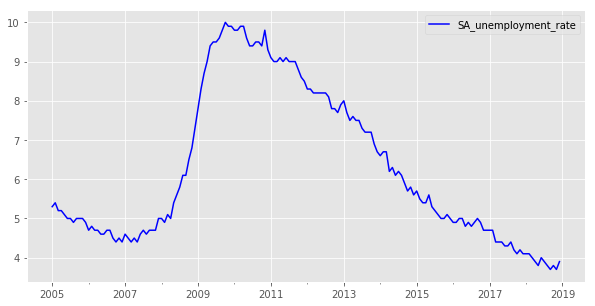

In [9]:
df_UE['2005-01-01':].plot(figsize=[10,5],color='blue')

In [ ]:
pd.plotting.autocorrelation_plot(df_UE)
# Autocorrelation = Matching our feature and time; How closely is the information given by time equal to the target feature
# Shows there is a high level of positive correlation between recent periods, but decays over time the correlation tends to center around the 0 mean
# Might need to consider adding additional normalization

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(df_UE);

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,window=12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean - {}'.format(str(window)))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(df_UE.seasonally_adjusted_unemployment_rate)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries,window=12):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = list(adfuller(timeseries, autolag='AIC'))
    print(dftest[4])
    crit_values = []
    for key,value in dftest[4].items():
        crit_values.append(value)
    print(crit_values)
    dfoutput = pd.DataFrame(list(dftest[0:4])+crit_values, index=['Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Value (%s) 1%','Critical Value (%s) 5%','Critical Value (%s) 10%'],columns=['Results'])
    return dfoutput

In [ ]:
adfuller = test_stationarity_2(df_UE.seasonally_adjusted_unemployment_rate)

In [ ]:
tester = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/solar.csv')
tester.to_dict('rows')

In [ ]:
adfuller.to_dict('data')["Results"]

In [ ]:
# Will remove the rolling average as a naive attempt to reduce noise, but keep tendencies of the data

def use_rol_mean(pd_series, window=12):
    rolmean = pd_series.rolling(window).mean()
    data_minus_rolmean = pd_series - rolmean
    # Adding in rolmean creates NaNs for first year
    data_minus_rolmean.dropna(inplace=True)

    # Plot rollingmean
    fig = plt.figure(figsize=(11,7))
    orig = plt.plot(pd_series, color='blue',label='Original')
    plt.plot(data_minus_rolmean, color='red',label='Rolling mean - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling means are subtracted from Original')
    plt.show(block=False)
    return data_minus_rolmean

In [ ]:
df_UE_rol_mean = use_rol_mean(df_UE,12)

In [ ]:
# Very Low p-value; 12 month lag
test_stationarity(df_UE_rol_mean.seasonally_adjusted_unemployment_rate)

In [ ]:
df_UE_rol_mean['seasonally_adjusted_unemployment_rate'] = pd.to_numeric(df_UE_rol_mean.seasonally_adjusted_unemployment_rate,downcast='float')
df_UE_rol_mean.columns = ['Unemployment Rate (Standardized)']

In [ ]:
df_UE_gt = df_UE_rol_mean['2005-01-01':]
df_UE_all = df_UE_rol_mean

In [ ]:
df_UE_all.plot()

In [ ]:
df_UE_gt.plot()

In [ ]:
def arima_modeler(data,pdq_lower,pdq_upper,m):
    p = d = q = range(pdq_lower, pdq_upper)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data,
                                order=ans_df.loc[ans_df['aic'].idxmin()][0],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    return output

In [ ]:
# BEGIN UE ALL TESTING

In [ ]:
arima_output = arima_modeler(df_UE_all,0,2,12)

In [ ]:
arima_output.plot_diagnostics()

In [ ]:
arima_output.summary()

In [ ]:
pred = arima_output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_UE_all['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
# Determine MSE/RMSE

y_forecasted = np.array(pred.predicted_mean)
y_truth = np.array(df_UE_all['2017-01-01':])
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 5)))

In [ ]:
# BEGIN IN-SCOPE MODELLING

In [ ]:
df_UE_gt.dtypes

In [ ]:
arima_output_gt = arima_modeler(df_UE_gt,0,2,12)

In [ ]:
arima_output_gt.plot_diagnostics()

In [ ]:
arima_output_gt.summary()

In [ ]:
pred = arima_output_gt.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_UE_all['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Unemployment Rate')
plt.legend()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Determine MSE/RMSE

y_forecasted = np.array(pred.predicted_mean)
y_truth = np.array(df_UE_gt['2018-01-01':])
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 5)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 5)))
print('The Mean Average Percent Error is {}'.format(round(mean_absolute_percentage_error(y_forecasted,y_truth), 5)))